In [432]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PWD = Path.cwd()

In [433]:
df = pd.read_csv(
    f'{PWD}/LLM+Answer+Evaluation_24+September+2024_10.23.tsv',
    sep='\t',
    encoding='utf-16',
)

questions = pd.read_json('../survey.jsonl', lines=True)


datasets = questions['dataset'].unique()[:-1]
models = questions['model'].unique()
dataset_model_combinations = [(d, m) for d in datasets for m in models]

POINT_SCALE = 5


def t2i(
    text: str,
    point_scale: int = 5,
) -> int:
    if point_scale == 5:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 2,
            'Neither agree nor disagree': 3,
            'Somewhat agree': 4,
            'Strongly agree': 5,
        }
    elif point_scale == 3:
        mapping = {
            'Strongly disagree': 1,
            'Somewhat disagree': 1,
            'Neither agree nor disagree': 2,
            'Somewhat agree': 3,
            'Strongly agree': 3,
        }

    return mapping.get(text, None)


def i2t(
    integer: int,
    point_scale: int = 5,
) -> str:
    if point_scale == 5:
        mapping = {
            1: 'SD',
            2: 'sD',
            3: 'N',
            4: 'sA',
            5: 'SA',
        }
    elif point_scale == 3:
        mapping = {
            1: 'SD',
            2: 'N',
            3: 'SA',
        }

    return mapping.get(integer, None)

/tmp/ipykernel_17229/2056515921.py:1: DtypeWarning: Columns (4,5,6,9,10,11,12,13,14,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,43,44,45,46,47,48,49,50,51,58,59,60,64,65,66,67,68,69,70,71,72,76,77,78,91,92,93,94,95,96,100,101,102,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,265,266,267,268,269,270,271,272,273,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311

In [434]:
datasets, models

(array(['Franklin', 'GSM8k', 'HotpotQA', 'StrategyQA'], dtype=object),
 array(['google/gemma-2-9b-it', 'meta-llama/Meta-Llama-3.1-8B-Instruct',
        'microsoft/Phi-3.5-mini-instruct', 'openai/gpt-4o-mini'],
       dtype=object))

In [435]:
questions.head()

,uuid,is_attention_check,dataset,model,question,parsed_response,html
0,1c9b5176-426a-4204-846b-a3f8b500f14f,False,Franklin,google/gemma-2-9b-it,Which country will have the lower energy consu...,"I do not have access to real-time information,...",<p><em>Which country will have the lower energ...
1,a58302d2-d144-4f4f-8f3b-b56220312d6b,False,Franklin,google/gemma-2-9b-it,Which country in Northern Europe had the highe...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Northern Europe had th...
2,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee,False,Franklin,google/gemma-2-9b-it,Which country in Eastern Asia had the highest ...,Here's how to find the answer:\n\n* **Identify...,<p><em>Which country in Eastern Asia had the h...
3,f7f44e54-e848-4e48-a6d7-e1fa552754d4,False,Franklin,google/gemma-2-9b-it,For the country in Micronesia that had the low...,I cannot answer this question. \n\nHere's why:...,<p><em>For the country in Micronesia that had ...
4,da574fdf-3fc9-4191-a373-b015b3584e8b,False,Franklin,google/gemma-2-9b-it,Which country will have the higher life expect...,Here's how to approach this question:\n\n* **L...,<p><em>Which country will have the higher life...


In [436]:
df[['duration', 'PROLIFIC_PID', 'finished']]

,duration,PROLIFIC_PID,finished
0,Duration (in seconds),PROLIFIC_PID,Finished
1,554,60cd16e63d3924958e8d3d43,True
2,370,5e90a3adb3e1243bdcfaf973,True
3,397,60f20aac9a3cd813c94175b4,True
4,405,63ced2f25eb7beb158c802d5,True
...,...,...,...
263,2034,66bd63193bedc4e83a4ff056,True
264,2314,62371a5bc955df9ccc899bb0,True
265,1993,63b9d3abc3ddc61c8c08fd84,True
266,2517,65e74f3dd1cf1c6869f7af37,True


In [437]:
# set column name to item in row 0
df.columns = df.iloc[0]
# drop the first row
df = df.drop(0)
# set index to 'PROLIFIC_PID'
df = df.set_index('PROLIFIC_PID')
# remove rows where Finished is not True
df = df[df['Finished'] == 'True']
# get durations and remove outliers
durations = df['Duration (in seconds)'].astype(float).map(lambda x: x / 60)
# print some stats about duration
print(durations.describe())

count    248.000000
mean      17.587433
std        9.037307
min        3.533333
25%       11.683333
50%       15.750000
75%       20.654167
max       57.066667
Name: Duration (in seconds), dtype: float64


In [438]:
# get durations which are more than 3 standard deviations lower than the mean
outliers_time = durations.mean() - 3 * durations.std()
print(f'Minimum permissible time: {outliers_time} minutes')
outliers = durations[durations < outliers_time]
print(outliers)
# remove outliers
df = df[~df.index.isin(outliers.index)]

Minimum permissible time: -9.524487360093925 minutes
Series([], Name: Duration (in seconds), dtype: float64)


In [439]:
# find the uuid in the string using regex to match a 36 character string
df.columns = df.columns.str.extract(r'([a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}_[1-4])')[0]
# only return columns where there is a match
df = df[df.columns.dropna()]
# drop columns with all NaN values
df = df.dropna(axis=1, how='all')

In [440]:
df.head()

,1c9b5176-426a-4204-846b-a3f8b500f14f_1,1c9b5176-426a-4204-846b-a3f8b500f14f_2,1c9b5176-426a-4204-846b-a3f8b500f14f_3,a58302d2-d144-4f4f-8f3b-b56220312d6b_1,a58302d2-d144-4f4f-8f3b-b56220312d6b_2,a58302d2-d144-4f4f-8f3b-b56220312d6b_3,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_1,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_2,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_3,f7f44e54-e848-4e48-a6d7-e1fa552754d4_1,...,f6ca623b-3b04-45b2-9909-51ac4a2ef449_3,3efe2b88-9e40-4a1c-8587-ac7b524f9233_1,3efe2b88-9e40-4a1c-8587-ac7b524f9233_2,3efe2b88-9e40-4a1c-8587-ac7b524f9233_3,9b038805-caa5-4e34-ba1c-83856376c705_1,9b038805-caa5-4e34-ba1c-83856376c705_2,9b038805-caa5-4e34-ba1c-83856376c705_3,6f401f5d-264c-4bd3-98a2-e3e0826eef74_1,6f401f5d-264c-4bd3-98a2-e3e0826eef74_2,6f401f5d-264c-4bd3-98a2-e3e0826eef74_3
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
60cd16e63d3924958e8d3d43,NaN,NaN,NaN,Strongly disagree,Strongly disagree,Strongly disagree,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e90a3adb3e1243bdcfaf973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neither agree nor disagree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60f20aac9a3cd813c94175b4,NaN,NaN,NaN,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63ced2f25eb7beb158c802d5,NaN,NaN,NaN,NaN,NaN,NaN,Strongly disagree,Strongly disagree,Strongly disagree,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615e172f0c76d81d3ac38937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strongly disagree,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Attention checks

In [441]:
attention_check_agree_uuid = 'd67998d7-8f14-4f50-823b-cb63027f21d9'
attention_check_disagree_uuid = 'e45763f5-53c4-4006-b2f8-edfbfd7e289e'
attention_check_somewhat_agree = [f'{attention_check_agree_uuid}_{i}' for i in range(1, 5)]
attention_check_strongly_disagree = [f'{attention_check_disagree_uuid}_{i}' for i in range(1, 5)]
# make a dataframe with the attention check columns
attention_check_df = df[attention_check_somewhat_agree + attention_check_strongly_disagree]

# just to confirm, get all questions from df which end in _4
# attention_check_df = df.filter(regex='_4$', axis=1)

# drop these columns from the dataframe
df = df.drop(attention_check_df.columns, axis=1)
# confirm specific columns contains the correct values
failed_checks = attention_check_df[~attention_check_df['d67998d7-8f14-4f50-823b-cb63027f21d9_4'].isin(['Somewhat agree'])]
failed_checks = pd.concat(
    [
        failed_checks,
        attention_check_df[~attention_check_df['e45763f5-53c4-4006-b2f8-edfbfd7e289e_4'].isin(['Strongly disagree'])],
    ]
)
# rename a column
failed_checks = failed_checks.rename(
    columns={
        'd67998d7-8f14-4f50-823b-cb63027f21d9_4': 'Somewhat agree',
        'e45763f5-53c4-4006-b2f8-edfbfd7e289e_4': 'Strongly disagree',
    }
)
failed_checks[['Somewhat agree', 'Strongly disagree']]

,Somewhat agree,Strongly disagree
PROLIFIC_PID,,
55884887fdf99b4020ba09bb,Somewhat disagree,Strongly disagree
66a25dc86f877fad5ce20223,Strongly agree,Strongly agree
5e86c11942701c2ffda5d113,Somewhat disagree,Strongly disagree
6655d895e8c33b7738009342,Neither agree nor disagree,Strongly disagree
66d82bed7186e76bbd4e9f87,Somewhat disagree,Strongly disagree
66ae46354f66a46055daf8f7,Neither agree nor disagree,Somewhat agree
65de5c8f7461ee4ad081dd65,Strongly agree,Strongly disagree
602a2911a73ba046955f6c58,Strongly agree,Strongly agree
6396044f6ae489bb820c67a5,Strongly agree,Strongly agree


In [442]:
print(f'Failed attention checks: {len(failed_checks)} ({len(failed_checks) / len(df) * 100:.2f}%)')
# compare values in rows and check if they match the column name
failed_checks['Somewhat agree'] = failed_checks['Somewhat agree'].map(lambda x: x == 'Somewhat agree')
failed_checks['Strongly disagree'] = failed_checks['Strongly disagree'].map(lambda x: x == 'Strongly disagree')
# get rows where both values are True
failed_both = failed_checks[failed_checks.all(axis=1)]
print(f'Failed both attention checks: {len(failed_both)} ({len(failed_both) / len(df) * 100:.2f}%)')
print(f'Participants failed: [{", ".join(failed_checks.index)}]')

Failed attention checks: 28 (11.29%)
Failed both attention checks: 0 (0.00%)
Participants failed: [55884887fdf99b4020ba09bb, 66a25dc86f877fad5ce20223, 5e86c11942701c2ffda5d113, 6655d895e8c33b7738009342, 66d82bed7186e76bbd4e9f87, 66ae46354f66a46055daf8f7, 65de5c8f7461ee4ad081dd65, 602a2911a73ba046955f6c58, 6396044f6ae489bb820c67a5, 66704e9e669e722abcd02aa6, 585d139a460cb5000183f705, 59e7232f24d7bf00012f112e, 66d09cad71f1aa6d4835f142, 6659c9abe870396b7be8ea34, 66c4eb33c6ea3ce75318b5bc, 66a25dc86f877fad5ce20223, 5b7d4bd487d85f0001ba8b6e, 66548cf3c4c63418286fc428, 66db7fdfdace7432da530fef, 66ae46354f66a46055daf8f7, 66e04be8eee549c122da56b0, 63fa6269a045cb36f1757a59, 602a2911a73ba046955f6c58, 6396044f6ae489bb820c67a5, 66704e9e669e722abcd02aa6, 585d139a460cb5000183f705, 63d5daa80d80a745de740c13, 62db2644ab0a3a353c0dcb54]


In [443]:
# convert text to integer
point_scale = 5
df = df.map(lambda x: t2i(x, point_scale))

In [444]:
# get rows where all non-NaN values are the same
rows = df.apply(lambda x: len(set(x.dropna())) == 1, axis=1)
# print rows where value is true and not false
rows = rows[rows == True]
print(f'Rows with same values: {len(rows)} ({len(rows) / len(df) * 100:.2f}%)')
# drop these rows from the dataframe
df = df.drop(rows.index)

Rows with same values: 0 (0.00%)


In [445]:
"""
Split main dataframe into 3 dataframes for each variation of the question.
Split also by dataset and model.
"""
# get uuids in survey
uuids_in_survey = {i.split('_')[0] for i in df.columns}
# get questions where questions['uuid'] is in uuids_in_survey
questions = questions[questions['uuid'].isin(uuids_in_survey)]
# many-to-one mapping between ('model', 'dataset') and 'uuid'. get uuids for each ('model', 'dataset') pair
grouped_uuids = questions.groupby(['dataset', 'model'])['uuid'].apply(list).to_dict()
# each uuid contains 3 variations with suffixes _1, _2, _3. create separate dataframes for each variation
ask, plan, sat = {}, {}, {}
for (dataset, model), uuids in grouped_uuids.items():
    ask[(dataset, model)] = df[[f'{uuid}_1' for uuid in uuids]]
    plan[(dataset, model)] = df[[f'{uuid}_2' for uuid in uuids]]
    sat[(dataset, model)] = df[[f'{uuid}_3' for uuid in uuids]]

all_ask = pd.concat(ask.values(), axis=1)
all_plan = pd.concat(plan.values(), axis=1)
all_sat = pd.concat(sat.values(), axis=1)

ask_mean_std = []
plan_mean_std = []
sat_mean_std = []

for dataset, model in grouped_uuids:
    ask_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [ask[(dataset, model)].std().mean()],
        }
    )
    plan_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [plan[(dataset, model)].std().mean()],
        }
    )
    sat_mean_std.append(
        {
            'dataset': [dataset],
            'model': [model],
            'mean std': [sat[(dataset, model)].std().mean()],
        }
    )

ask[('Franklin', 'google/gemma-2-9b-it')]

,1c9b5176-426a-4204-846b-a3f8b500f14f_1,a58302d2-d144-4f4f-8f3b-b56220312d6b_1,dd5b27fd-4de8-42b6-b068-9e9f4c80e1ee_1,f7f44e54-e848-4e48-a6d7-e1fa552754d4_1,da574fdf-3fc9-4191-a373-b015b3584e8b_1,de4a0a3f-2121-47e5-83bd-e674f09e0508_1,a103ec1b-f043-4040-8758-bf365f90be33_1,7f117d44-c692-440b-a290-b2032ac041e9_1,caa7505c-2b43-4238-9dd9-a15431852fa1_1,68356e25-9a13-4687-8d1d-f33b3f8c6603_1,...,09dfe96f-5f87-4676-82a4-dc76f1ebc6c3_1,2cf79e36-af1b-43d1-b3c0-e53d5646a3e9_1,ba98d636-2fe7-4504-9128-15601b5b06d8_1,c8a6b721-5c06-40e7-80d9-68dbfe56cdbb_1,d846cc1a-608f-4ba5-85b6-e9745316f73f_1,0d81e9dc-fd65-440e-8c16-0a734606f1ed_1,bfb3e7a3-b84f-4784-919e-893b600d848f_1,12ba8ba1-a29d-42d7-90b3-d9897aba310f_1,9b8865d2-df5d-4ef0-a55d-07886940d325_1,8e486636-cdce-4075-8087-ed1539398766_1
PROLIFIC_PID,,,,,,,,,,,,,,,,,,,,,
60cd16e63d3924958e8d3d43,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e90a3adb3e1243bdcfaf973,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60f20aac9a3cd813c94175b4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63ced2f25eb7beb158c802d5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615e172f0c76d81d3ac38937,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65847ecf0896ca006d2c00b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5a5a6ed7f6c517000195029e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63174af7d57182f9bf90c094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [446]:
def remove_outliers(
    df_dict: dict[tuple, pd.DataFrame],
) -> dict[tuple, pd.DataFrame]:
    """Remove outliers from a dataframe using the IQR method.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model with outliers removed.

    """

    def get_outliers(df):
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1

        outlier_columns = df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]

        return outlier_columns

    outliers = {}
    outliers_removed = {}

    for (dataset, model), df in df_dict.items():
        outliers_df = get_outliers(df)
        outliers_removed[(dataset, model)] = df[~outliers_df.notna().any(axis=1)]
        outliers[(dataset, model)] = outliers_df
        # percentage of outliers for a given dataset and model
        # outlier_info.append(
        #     {
        #         'dataset': dataset,
        #         'model': model,
        #         'percentage': outliers.count().sum() / df.shape
        #     }
        # )

    return outliers_removed, outliers


# ask, ask_outliers = remove_outliers(ask)
# plan, plan_outliers = remove_outliers(plan)
# sat, sat_outliers = remove_outliers(sat)

In [447]:
def majority_vote(df_dict: dict[tuple, pd.DataFrame]) -> pd.DataFrame:
    """Majority vote for a dataframe.

    Parameters
    ----------
    df_dict : dict[tuple, pd.DataFrame]
        A dictionary containing dataframes with the key being a tuple of the dataset and model.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the majority vote for each dataset and model.

    """
    for (dataset, model), df in df_dict.items():
        # for each column in df
        for column in df.columns:
            # get the most common value(s) in the column, averaging if there are multiple
            most_common = df[column].mode().mean()
            # set all values in the column to the most common value
            df[column] = most_common

        df_dict[(dataset, model)] = df

    return df_dict


# ask = majority_vote(ask)
# plan = majority_vote(plan)
# sat = majority_vote(sat)

In [448]:
dataset = 'Franklin'
# dataset = 'GSM8k'
# dataset = 'HotpotQA'
# dataset = 'StrategyQA'
# model = 'google/gemma-2-9b-it'
# model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
# model = 'openai/gpt-4o-mini'

In [449]:
# do sem for each dataset and model, taking random samples of 4 responses from each column
# check if sem increases with fewer responses


def compute_sem(
    df_dict: dict[tuple, pd.DataFrame],
) -> pd.DataFrame:
    rows = []
    for (dataset, model), dataframe in ask.items():
        # remove nan values
        df = [col[~np.isnan(col)] for col in dataframe.values.T]
        # compute sem for all 8 responses across all columns
        sem = pd.Series([pd.Series(col).sem() for col in df])
        sem_mean = sem.mean()
        # get mean value for all cols
        mean = pd.Series([pd.Series(col).mean() for col in df]).mean()
        # get std value for all cols
        std = pd.Series([pd.Series(col).std() for col in df]).mean()

        sem = rows.append(
            {
                'dataset': dataset,
                'model': model,
                'mean': mean,
                # 'std': std,
                'sem-mean': sem_mean,
            }
        )

    # floats to 3 decimal places
    df = pd.DataFrame(rows).round(2)

    return df


compute_sem(ask)

,dataset,model,mean,sem-mean
0,Franklin,google/gemma-2-9b-it,1.95,0.38
1,Franklin,meta-llama/Meta-Llama-3.1-8B-Instruct,1.96,0.21
2,Franklin,microsoft/Phi-3.5-mini-instruct,2.44,0.56
3,Franklin,openai/gpt-4o-mini,3.00,0.43
4,GSM8k,google/gemma-2-9b-it,4.71,0.17
5,GSM8k,meta-llama/Meta-Llama-3.1-8B-Instruct,4.56,0.35
6,GSM8k,microsoft/Phi-3.5-mini-instruct,3.84,0.48
7,GSM8k,openai/gpt-4o-mini,4.84,0.14
8,HotpotQA,google/gemma-2-9b-it,3.74,0.39
9,HotpotQA,meta-llama/Meta-Llama-3.1-8B-Instruct,2.29,0.31


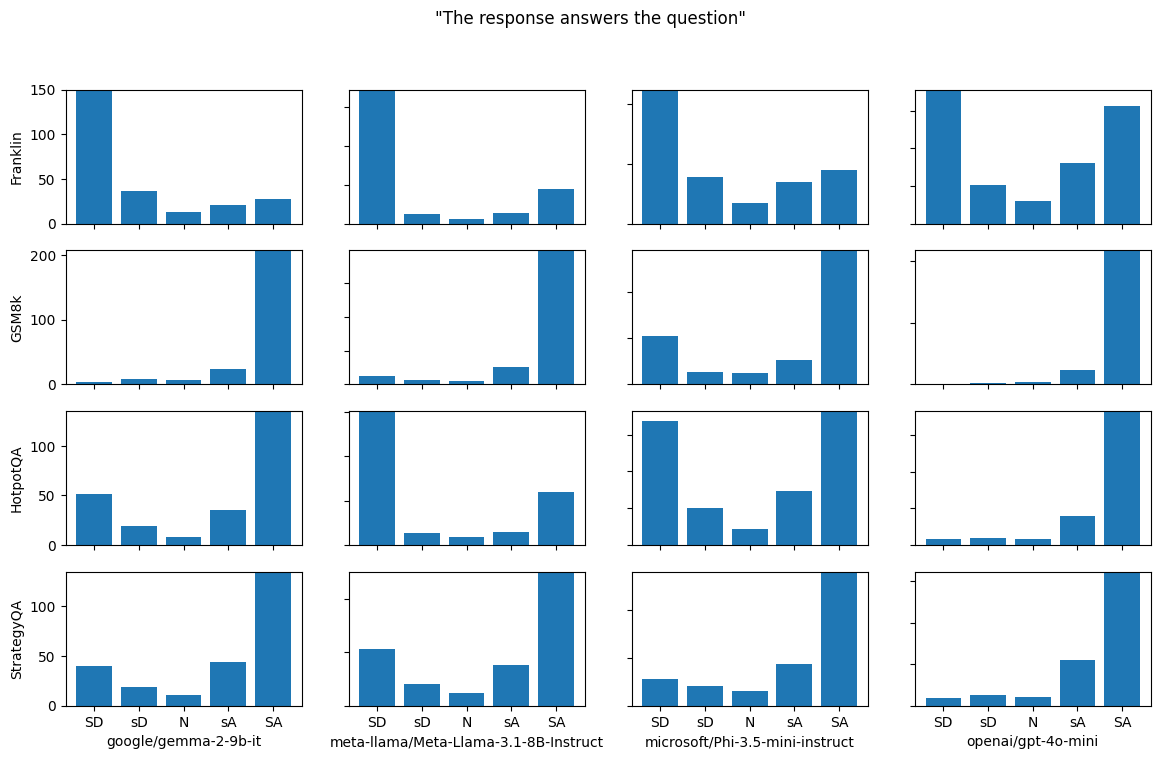

In [450]:
point_scale = 5

# subplots in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(14, 8))

for d, dataset in enumerate(datasets):
    for m, model in enumerate(models):
        values = ask[(dataset, model)].to_numpy()
        # remove nan values from numpy array
        values = values[~pd.isna(values)]
        # frequency of each value
        counts = pd.Series(values).value_counts()
        # plot the frequency of each value
        axs[d, m].bar(counts.index, counts.values)
        # set x axis to i2t for each value
        axs[d, m].set_xticks(range(1, point_scale + 1))
        axs[d, m].set_xticklabels([i2t(i, point_scale) for i in range(1, point_scale + 1)], ha='center')
        # set y axis to 0-max frequency
        axs[d, m].set_ylim(0, counts.max())
        # set x axis label to the model
        axs[d, m].set_xlabel(model)
        # set y axis label to the dataset
        axs[d, m].set_ylabel(dataset)

# only show bottom x axis labels
for ax in axs.flat:
    ax.label_outer()

# set the title of the entire plot
fig.suptitle('"The response answers the question"')
plt.show()

In [451]:
dataset = 'Franklin'
dataset = 'GSM8k'
dataset = 'HotpotQA'
dataset = 'StrategyQA'
model = 'google/gemma-2-9b-it'
model = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model = 'microsoft/Phi-3.5-mini-instruct'
model = 'openai/gpt-4o-mini'
# get questions['question'] with uuids from grouped_uuids[(dataset, model)]
questions = questions[(questions['dataset'] == dataset) & (questions['model'] == model)]

In [452]:
questions

,uuid,is_attention_check,dataset,model,question,parsed_response,html
960,12c4c6a9-792e-4cd3-9330-c0b502e5c3e5,False,StrategyQA,openai/gpt-4o-mini,Does Princess Peach's dress resemble a peach f...,Princess Peach's dress does not directly resem...,<p><em>Does Princess Peach's dress resemble a ...
961,02b1fc1c-fbdc-4de4-b5cc-d64ed1c35caa,False,StrategyQA,openai/gpt-4o-mini,Would General Zod prefer an iPhone over a Sams...,While General Zod is a fictional character fro...,<p><em>Would General Zod prefer an iPhone over...
962,a97414d6-9b72-427c-b29d-c0818677ad9f,False,StrategyQA,openai/gpt-4o-mini,Would a honey badger fit inside an oven?,"Honey badgers are relatively small animals, ty...",<p><em>Would a honey badger fit inside an oven...
963,ee49d864-b307-4761-a271-ee6abbebe166,False,StrategyQA,openai/gpt-4o-mini,Could ten gallons of seawater crush a six year...,"Ten gallons of seawater, while heavy, would no...",<p><em>Could ten gallons of seawater crush a s...
964,b73426f3-fa0d-4d60-a4a5-46d24afd848e,False,StrategyQA,openai/gpt-4o-mini,Are there Pink music videos that are triggerin...,"Yes, some music videos by Pink, like those of ...",<p><em>Are there Pink music videos that are tr...
...,...,...,...,...,...,...,...
1019,6a0fc6a7-cbed-478d-a950-4b78738e1c12,False,StrategyQA,openai/gpt-4o-mini,Can Cyril Ramaphosa become Secretary General o...,"Cyril Ramaphosa, as the President of South Afr...",<p><em>Can Cyril Ramaphosa become Secretary Ge...
1020,f6ca623b-3b04-45b2-9909-51ac4a2ef449,False,StrategyQA,openai/gpt-4o-mini,Can a snake swallow an M60 Patton?,"No, a snake cannot swallow an M60 Patton tank....",<p><em>Can a snake swallow an M60 Patton?</em>...
1021,3efe2b88-9e40-4a1c-8587-ac7b524f9233,False,StrategyQA,openai/gpt-4o-mini,Would it be unusual to find a yellow perch in ...,"Yes, it would be unusual to find a yellow perc...",<p><em>Would it be unusual to find a yellow pe...
1022,9b038805-caa5-4e34-ba1c-83856376c705,False,StrategyQA,openai/gpt-4o-mini,Did Electronic Arts profit from Metroid sales?,"No, Electronic Arts (EA) did not profit from M...",<p><em>Did Electronic Arts profit from Metroid...
